<a href="https://colab.research.google.com/github/yoonseong00/colab/blob/main/%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89_%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### 본격적으로 <Part 2>를 시작하기에 앞서, <Part 1>에서 수행해주었던 작업들을 다시 수행

In [7]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 이 두 줄의 코드는 matplotlib의 기본 scheme말고, seaborn scheme을 세팅해준다
# 일일이 graph의 font size를 지정할 필요 없이, seaborn의 font_scale을 사용하면 편리하다
plt.style.use('seaborn')
sns.set(font_scale = 2.5)

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

In [8]:
df_train=pd.read_csv("/content/drive/MyDrive/train.csv")
df_test=pd.read_csv("/content/drive/MyDrive/test.csv")
# SibSp, Parch 변수를 하나의 변수(FamilySize)로 합쳐준다
# 자신을 포함해야하므로, 1 을 더해준다
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [9]:

# 정규표현식을 사용하여 title을 추출
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

# 위에서 생성된 테이블을 참고하여 남자, 여자가 쓰는 Initial을 구분
df_train['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major',
                             'Lady', 'Countess', 'Jonkheer', 'Col',
                             'Rev', 'Capt', 'Sir', 'Don', 'Dona'],
                            ['Miss', 'Miss', 'Miss', 'Mr', 'Mr',
                             'Mrs', 'Mrs', 'Other', 'Other',
                             'Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace = True)

df_test['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major',
                            'Lady', 'Countess', 'Jonkheer', 'Col',
                            'Rev', 'Capt', 'Sir', 'Don', 'Dona'],
                           ['Miss', 'Miss', 'Miss', 'Mr', 'Mr',
                            'Mrs', 'Mrs', 'Other', 'Other',
                            'Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace = True)

# Feature Engineering(특성 공학)

## Fare 변수

In [10]:
# 1. Null 값 대체
# 테스트 데이터 셋의 Fare 변수에 존재하는 Null 값을 평균값으로 대체
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

- 테스트 데이터 셋에 있는 NULL 값을 Fared의 평균값으로 대체

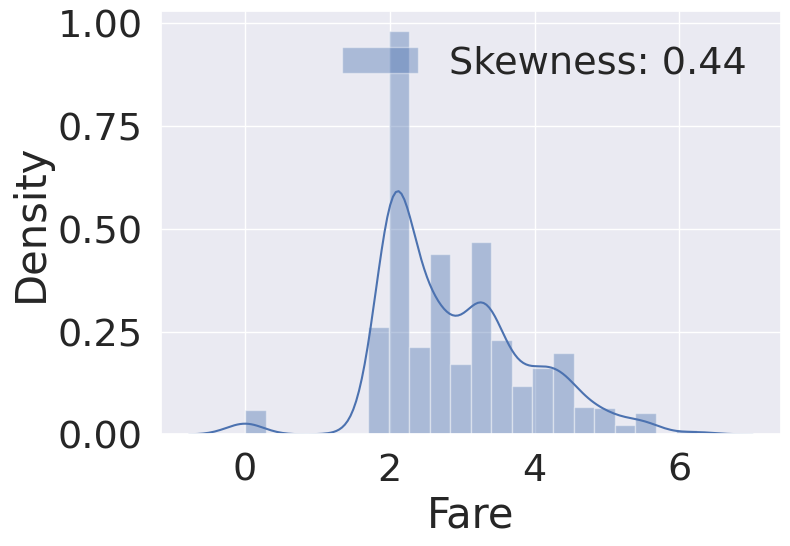

In [11]:
# 2. 로그 변환
# apply 대신 map을 사용해도 결과는 동일
#소수점 이하 두 자리까지만 나타내려면 {:.2f}와 같이 표현
df_train['Fare'] = df_train['Fare'].apply(lambda x: np.log(x) if x > 0 else 0)
df_test['Fare'] = df_test['Fare'].apply(lambda x: np.log(x) if x > 0 else 0)

fare_hist = sns.distplot(df_train['Fare'], label = 'Skewness: {:.2f}'.format(df_train['Fare'].skew()))
fare_hist = fare_hist.legend(loc = 'best')

- part1에서 로그 변환을 안했을 때는 왜도가 4 이상이 나와 오른꼬리 모양이 나왔는데, 로그변환을 취한 후 왜도가 절대값 0.5보다 작은 값이 나와 치우침이 개선되었다고 볼 수 있다.
- 이렇게 **로그 변환된 Fare 변수도 모델의 Feature**로 넣을 것이다.

## Age 변수

In [12]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamilySize       0
Initial          0
dtype: int64

- 보다 싶이 Age의 Null값은 177개이다.
- 이를 채우기 위해, part1에서 한 Initial 변수를 사용

In [13]:
# 1. Null 값 대체
# Age 변수에 존재하는 Null 값들을 Age 변수의 평균값으로 대체하기 위해, 평균값들을 확인
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


In [14]:

# 학습 데이터 셋과 테스트 데이터 셋에 존재하는 Age 변수의 Null 값들을 평균 값들로 대체
df_train.loc[(df_train.Age.isnull()) & (df_train['Initial'] == 'Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull()) & (df_train['Initial'] == 'Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull()) & (df_train['Initial'] == 'Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull()) & (df_train['Initial'] == 'Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull()) & (df_train['Initial'] == 'Other'), 'Age'] = 46

df_test.loc[(df_test.Age.isnull()) & (df_test['Initial'] == 'Master'), 'Age'] = 5
df_test.loc[(df_test.Age.isnull()) & (df_test['Initial'] == 'Miss'), 'Age'] = 22
df_test.loc[(df_test.Age.isnull()) & (df_test['Initial'] == 'Mr'), 'Age'] = 33
df_test.loc[(df_test.Age.isnull()) & (df_test['Initial'] == 'Mrs'), 'Age'] = 36
df_test.loc[(df_test.Age.isnull()) & (df_test['Initial'] == 'Other'), 'Age'] = 46

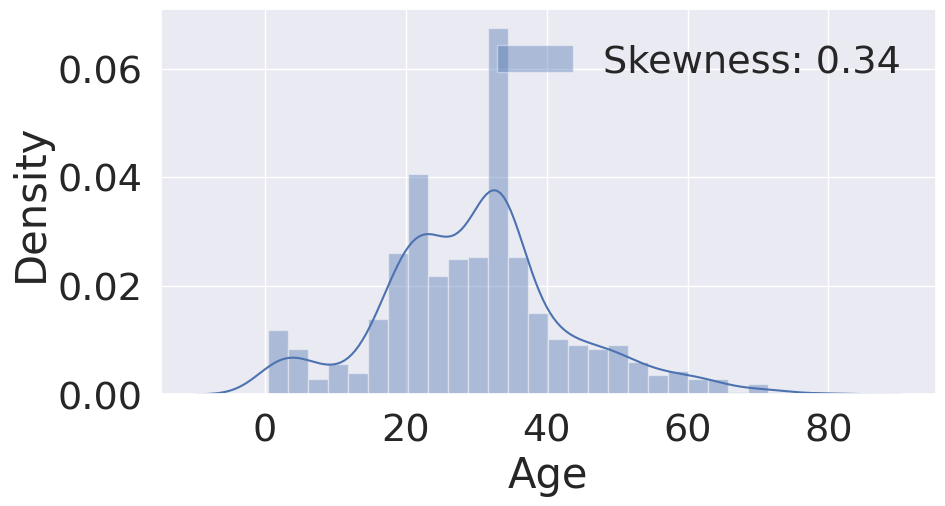

In [15]:
plt.figure(figsize = (10, 5))
age_full_hist = sns.distplot(df_train['Age'], label = 'Skewness: {:.2f}'.format(df_train['Age'].skew()))
age_full_hist = age_full_hist.legend(loc = 'best')
# loc = 'best' 여기서 loc를 best로 해주는 이유는 best가 알아서 계산하여 최적의 위치에 레전드를 위치시킨다.

- 튜토리얼에서는 가장 높은 첨도의 값이 0.04가 넘는데 내 그래프는 왜 못넘을가
- Age변수에 Null값을 평균으로 대체하니 치우침(왜도)가 조금 줄어들었다

### 연속형 변수인 Age를 범주화

In [16]:
def category_age(x):
    if x <= 16:
        return 0
    elif x <= 32:
        return 1
    elif x <= 48:
        return 2
    elif x <= 64:
        return 3
    else:
        return 4

df_train['Age_cat'] = df_train['Age'].apply(category_age)
df_test['Age_cat'] = df_test['Age'].apply(category_age)

In [17]:
# 이제 원래 컬럼인 Age를 제거해주겠다
df_train.drop(['Age'], axis = 1, inplace = True)
df_test.drop(['Age'], axis = 1, inplace = True)

## Family 변수

* 가족 수를 기준으로 3개의 범주로 범주화를시켜주겠다
    * FamilySize = 1, 2, 3 : "0"
    * FamilySize = 4, 5, 6 : "1"
    * FamilySize = 7, 8, 11 : "2"

In [18]:
def category_FamilySize(x):
    if x <= 3:
        return 0
    elif x <= 6:
        return 1
    else:
        return 2

df_train['FamilySize_cat'] = df_train['FamilySize'].apply(category_FamilySize)
df_test['FamilySize_cat'] = df_test['FamilySize'].apply(category_FamilySize)

del df_train['FamilySize']
del df_test['FamilySize']

In [19]:
df_train['FamilySize_cat'].value_counts()

0    800
1     66
2     25
Name: FamilySize_cat, dtype: int64

## Embarked 변수

- Embarked 변수에서 "S" 값이 가장 많으므로, 모든 Null 값들을 "S"로 대체

In [20]:
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [21]:
# Null 값 대체
df_train['Embarked'].fillna('S', inplace = True)

## 문자열 변수인 Initial, Embarked, Sex를 수치형 변수로 변환

### Initial 변수를 수치화

In [22]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

### Embarkded 변수를 수치화

In [23]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

### Sex 변수를 수치화

In [24]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

## 각 Feature 간의 상관관계를 수치화

* **피어슨 상관계수가 1 에 가까우면 양의 상관관계, -1 에 가까우면 음의 상관관계**이다.
* **피어슨 상관계수가 0** 이라는 것은 상관관계가 없다는 의미가 아니라, **선형적인 상관관계가 없다는 의미**이다.
  * 즉, **비선형적 상관관계는 존재할 수 있다!**

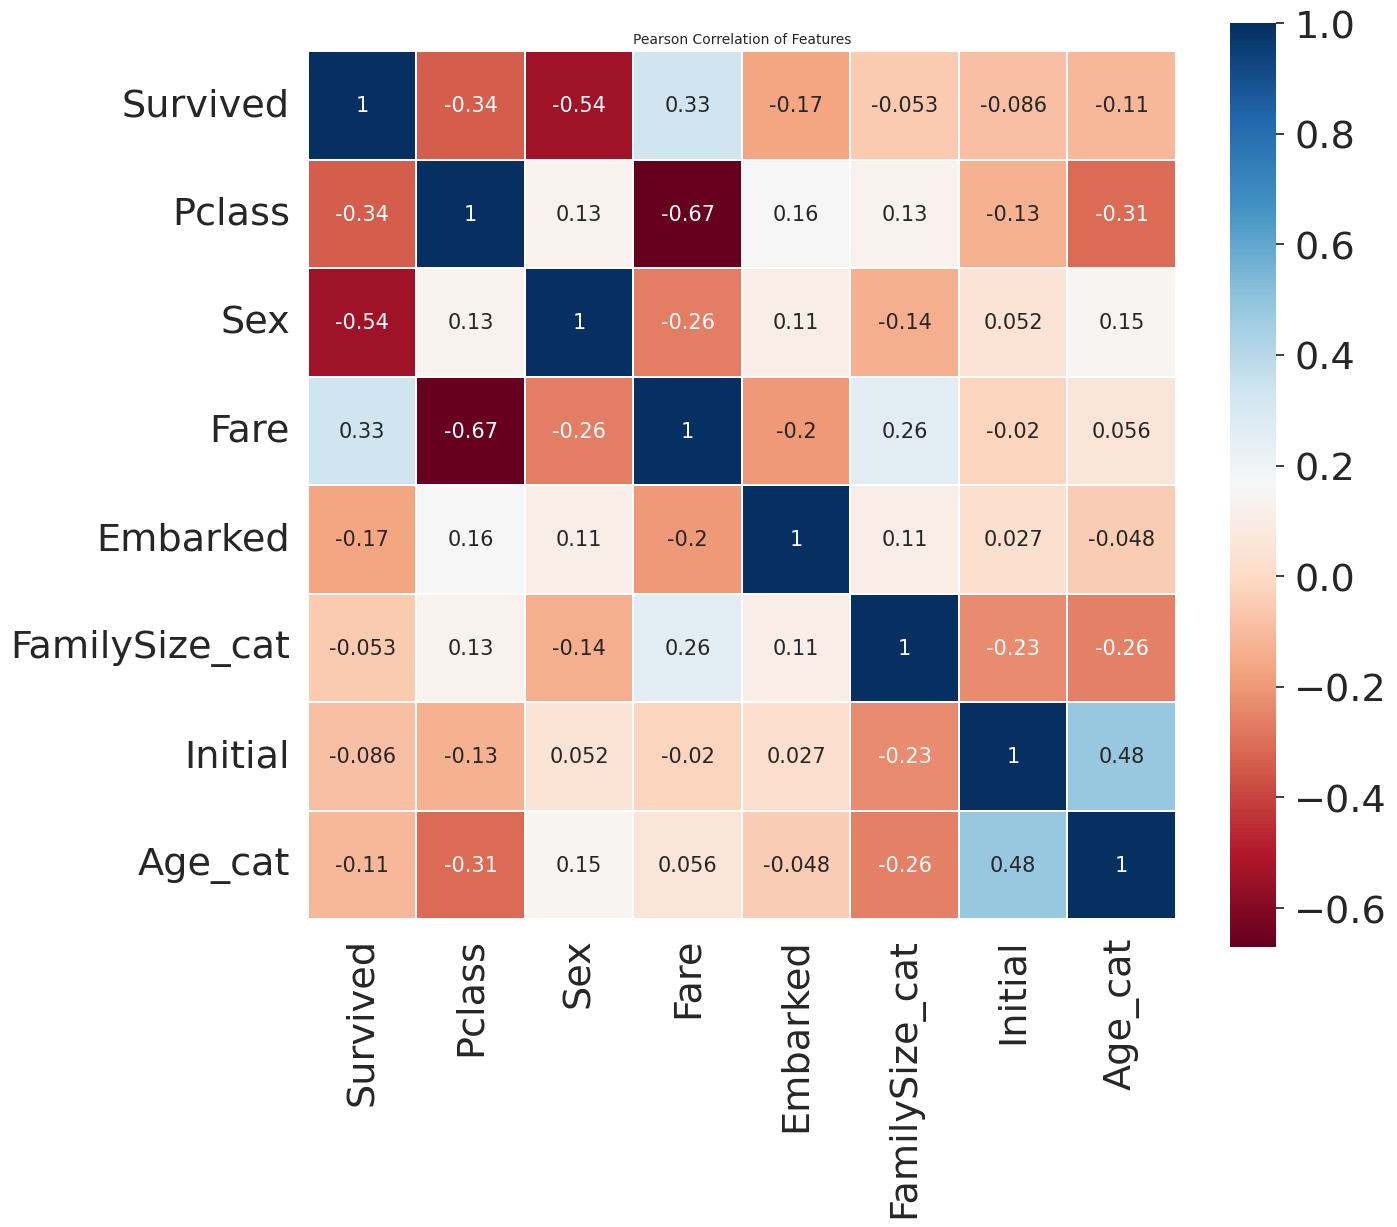

In [25]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex',
                         'Fare', 'Embarked', 'FamilySize_cat',
                         'Initial', 'Age_cat']]

colormap = plt.cm.RdBu

plt.figure(figsize = (14, 12))
plt.title('Pearson Correlation of Features', size = 10)
sns.heatmap(heatmap_data.astype(float).corr(), cmap = colormap, square = True,
            linecolor = 'white', linewidth = 0.1, annot = True, annot_kws = {'size': 15})

del heatmap_data

* 앞선 EDA 과정에서 살펴봤듯이, Sex와 Pclass 변수가 Survived 변수와 어느 정도 상관관계가 존재함을 알 수 있다.
* 하지만 서로 강한 상관관계를 갖는 feature들은 존재하지 않는 것을 확인할 수 있다.
  * 즉, 다중 공선성을 보이는 변수들이 존재하지 않는다는 의미이다.
  * 다시 말해, 모델 생성에 있어서 불필요한 feature가 없다는 말이다.

## One-Hot Encoding(원-핫 인코딩)

- 수치화를 시켜준 범주형 데이터를 그대로 모델에 넣어줘도 되지만, 모델의 성능을 높여주기 위해서 one-hot encoding 작업을 수행해주겠다.
  - 원-핫 인코딩이라는게 쉽게 말하면 가변수(더미변수)를 만들어주겠다는 말이랑 동일하다.
  - Pandas의 get_dummies()를 사용하면 쉽게 수행해 줄 수 있다.
    - prefix 옵션을 사용하면, 가변수에 공통으로 접두사를 추가할 수 있다.
    - drop_first = True 옵션을 설정하면, 가변수의 첫 번째 변수를 자동으로 삭제해준다.
      - 즉, 가변수 함정(dummy_trap)을 피할 수 있게 해준다 --> 총 (k-1)개의 가변수 생성!!

### Initial 변수에 대해서 One-Hot Encoding 처리

In [26]:
df_train = pd.get_dummies(df_train, columns = ['Initial'], prefix = 'Initial')
df_test = pd.get_dummies(df_test, columns = ['Initial'], prefix = 'Initial')

In [27]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,FamilySize_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,1,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,0,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,2,0,0,0,1,0,0


### Embarked 변수에 대해서 One-Hot Encoding 처리

In [28]:
df_train = pd.get_dummies(df_train, columns = ['Embarked'], prefix = 'Embarked')
df_test = pd.get_dummies(df_test, columns = ['Embarked'], prefix = 'Embarked')

In [29]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Age_cat,FamilySize_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,1,0,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,2,0,0,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,1,0,0,1,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,0,0,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,0,0,0,1,0,0,0,0,1


## 불필요한 컬럼 제거

- 실질적으로 분석에 사용할 feature들만 남기고 나머지는 제거해주겠다.

In [30]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis = 1, inplace = True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [31]:
df_train.head()

,Survived,Pclass,Sex,Fare,Age_cat,FamilySize_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,1,0,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,0,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,0,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,0,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,2,0,0,0,1,0,0,0,0,1


In [32]:
df_test.head()

,Pclass,Sex,Fare,Age_cat,FamilySize_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,2,0,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,0,0,0,0,1,0,0,0,1
2,2,1,2.270836,3,0,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,0,0,0,1,0,0,0,0,1
4,3,0,2.508582,1,0,0,0,0,1,0,0,0,1


# 머신러닝 모델 생성 및 예측

- 본 튜토리얼은 **0 과 1 로 이루어진 target 변수에 대한 예측**을 수행하는 모델을 만드는 것이다.
  - 즉, **이진 분류 문제**라고 할 수 있다.
- 우선 **학습 데이터 셋**에서 **Survived를 제외한** input을 가지고, **모델 최적화**를 수행해 줄 것이다.
- 그 후에 모델이 학습하지 않았던 **테스트 데이터 셋을 input**으로 주어서, **테스트 데이터 셋의 각 탑승객의 생존 여부를 예측**해보겠다.
- 이번 분석에서는 * **Logistic Regression, Decision Tree, Random Forest** * 이렇게 총 3개의 모델을 사용할 것이다.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

- 먼저 **학습 데이터 셋(train dataset)**과 **target label(Survived)**을 분리하겠다.

In [34]:
X_train = df_train.drop(['Survived'], axis = 1).values
y_target = df_train['Survived'].values
X_test = df_test.values

- 다음으로 ```train_test_split()```을 사용하여, **학습 데이터 셋**과 **테스트 데이터 셋**을 분할해준다.
  - 엄밀하게 말하면, **학습 데이터 셋(train dataset)과 검증 데이터 셋(valid dataset)으로 분할**하는 것이다.

In [35]:
# random_sate는 샘플링 재현성을 보정하기 위해 사용
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_target, test_size = 0.3, random_state = 2020)

## 모델 학습 및 예측

-** 본고사를 치르기 전에 모의고사를 여러 번 보는 것**이라고 생각하면 이해하기 쉽다.
- 즉, **본고사가 테스트 데이터 셋에 대해 평가하는 것**이라면, **모의고사는 교차 검중에서 많은 학습과 검증 데이트 셋에서 알고리즘 학습과 평가를 수행하는 것**이다.
- 3가지 모델에 대한 하이퍼 파라미터 튜닝은 따로 진행해주지 않겠다.

### 1. Logistic Regression

In [36]:
# 로지스틱 회귀의 경우, 정규성 가정이 필요하므로 "표준화" 작업을 수행
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_valid_std = scaler.transform(X_valid)

# 모델 학습 및 예측
lr = LogisticRegression()
lr.fit(X_train_std, y_train)
pred = lr.predict(X_valid_std)

print('Accuracy Score: {:.4f}'.format(accuracy_score(y_valid, pred)))

Accuracy Score: 0.8284


- 하이퍼 파라미터 튜닝을 따로 해주지 않은** 로지스틱 회귀 모델**의 경우, 예측 정확도가 약 **83%**로 나왔다.

### 2. Decision Tree

- 결정 트리 모델은 "표준화" 또는 "정규화" 작업을 수행해주지 않아도 된다

In [37]:
dt_clf = DecisionTreeClassifier(random_state = 2020)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_valid)

print('Accuracy Score: {:.4f}'.format(accuracy_score(y_valid, pred)))

Accuracy Score: 0.8172


- 하이퍼 파라미터 튜닝을 따로 해주지 않은 **결정 트리 모델**의 경우, 예측 정확도가 약 **82%**로 나왔다.

### 3. Random Forest

In [38]:
rf_clf = RandomForestClassifier(random_state = 2020)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_valid)

print('Accuracy Score: {:.4f}'.format(accuracy_score(y_valid, pred)))

Accuracy Score: 0.8470


- 하이퍼 파라미터 튜닝을 따로 해주지 않은 **랜덤 포레스트 모델**의 경우, 예측 정확도가 약 **85%**로 나왔다.

### <3개의 모델 성능 비교 결과>

- 랜덤 포레스트 모델의 예측 정확도가 가장 높게 나와 랜덤 포레스트 모델 사용

## **Feature** 중요도 확인

In [39]:
from pandas import Series

feature_importance = rf_clf.feature_importances_
Series_feat_imp = Series(feature_importance, index = df_test.columns)

In [40]:
df_test.columns

Index(['Pclass', 'Sex', 'Fare', 'Age_cat', 'FamilySize_cat', 'Initial_0',
       'Initial_1', 'Initial_2', 'Initial_3', 'Initial_4', 'Embarked_0',
       'Embarked_1', 'Embarked_2'],
      dtype='object')

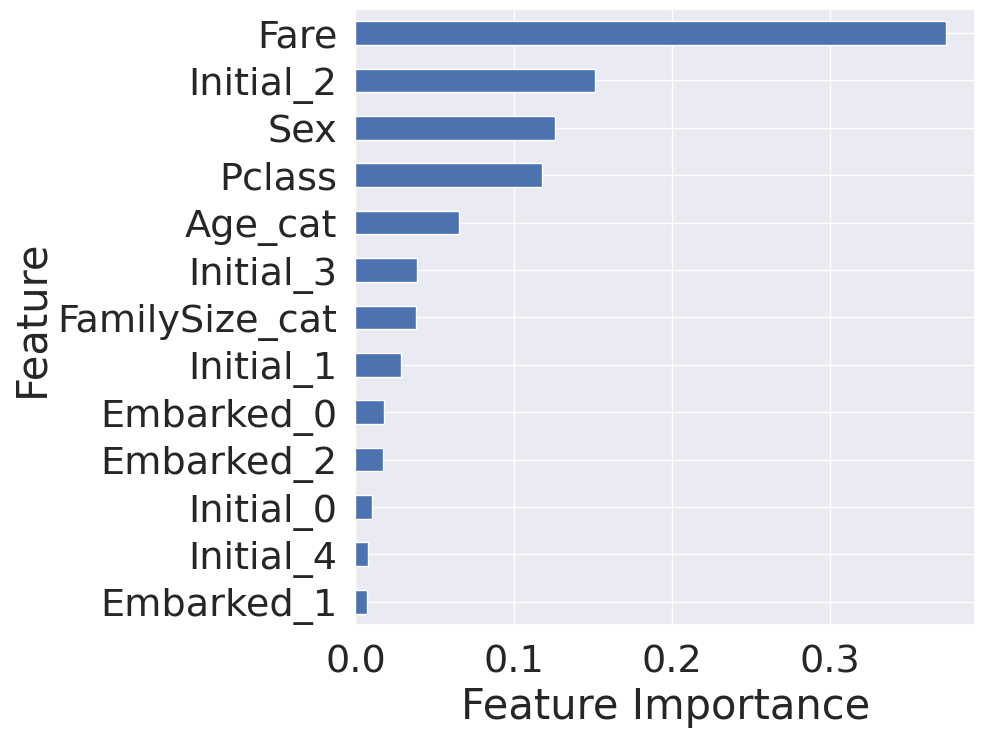

In [41]:
plt.figure(figsize = (8, 8))
Series_feat_imp.sort_values(ascending = True).plot.barh()
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

- Feature 중요도를 확인해본 결과 **Fare 변수**의 중요도가 가장 높은 것으로 확인

# 테스트 데이터 셋에 대해서 예측을 수행

- 이제 모델이 학습하지 않았던 테스트 데이터 셋을 input으로 넣어주고, 각 탑승객의 생존 여부를 예측해보겠다.
- Kaggle에서 준 파일인 **gender_submission.csv** 파일을 읽어와서 제출할 준비를 하겠다.

In [42]:
submission = pd.read_csv('/content/drive/MyDrive/gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [43]:
prediction = rf_clf.predict(X_test)
submission['Survived'] = prediction

In [44]:
submission.to_csv('./my_second_submission.csv', index = False)

In [51]:
submission.mean()

PassengerId    1100.500000
Survived          0.368421
dtype: float64